# Identifying Data Drift

Data drift occurs when the distribution of the input data changes over time.

Let's see in practice how to identify data drift. To do this, we will work with simulated data.

## Categorical Features

The first scenario will involve the analysis of **categorical features**.

Let's simulate a categorical variable used by a model. This feature takes the values **married, single and divorced** and we want to check whether the variable has the same distribution in the production data when compared to the training data.

Firstly, let's generate data:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

categories = ['Single', 'Married', 'Divorced']

# Generate two example datasets
dataset_train = np.random.choice(categories, size=1000, p=[0.49, 0.3, 0.21])
dataset_prod = np.random.choice(categories, size=1000, p=[0.50, 0.3, 0.2])

# Print example of generated data
print(dataset_train[:10])

['Divorced' 'Single' 'Single' 'Divorced' 'Single' 'Single' 'Single'
 'Single' 'Married' 'Married']


Now let's visually compare the feature at both times (training data and production data).

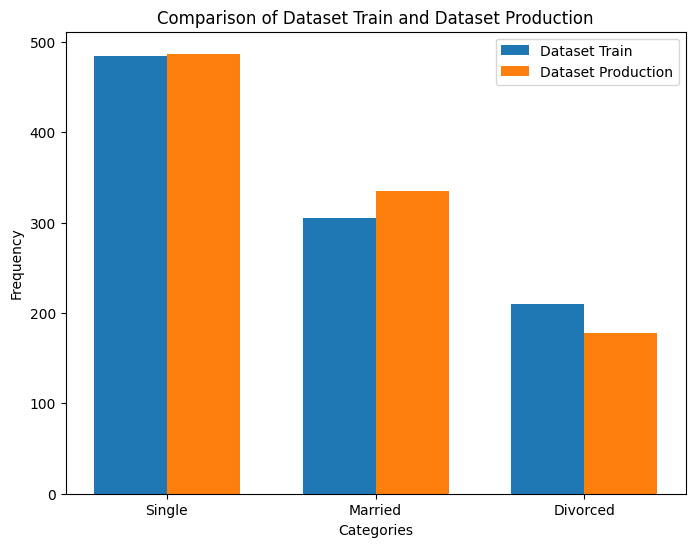

In [2]:
# Calculate frequencies
counts_train = [np.sum(dataset_train == category) for category in categories]
counts_prod = [np.sum(dataset_prod == category) for category in categories]

# Plot graph
plt.figure(figsize=(8, 6))

x = np.arange(len(categories))
width = 0.35

plt.bar(x - width / 2, counts_train, width, label="Dataset Train")
plt.bar(x + width / 2, counts_prod, width, label="Dataset Production")

plt.xlabel("Categories")
plt.ylabel("Frequency")
plt.title("Comparison of Dataset Train and Dataset Production")


plt.xticks(x, categories)
plt.legend()
plt.show()

Next, we will apply the **Chi-square test** to assess the goodness of fit. The test evaluates how well the observed data matches the expected distribution. The hypotheses for the statistical test are as follows:

- **Null hypothesis (H₀)**: The observed frequencies in each category align with the expected theoretical distribution.
- **Alternative hypothesis (H₁)**: The observed frequencies in at least one category deviate from the expected theoretical distribution.

In [5]:
def chi_square_test(dataset_train: np.ndarray, dataset_prod: np.ndarray, alpha: float = 0.05) -> float:
    """
    Perform a chi-squared test to check if there is a significant difference in the distribution of a categorical variable between two datasets.
    In other words, this test checks if there is data drift in the categorical variable distribution between the two datasets.

    Parameters:
    dataset_train (np.ndarray): Dataset for training.
    dataset_prod (np.ndarray): Dataset for production.
    alpha (float): Significance level.

    Returns:
    float: P-value of the chi-squared test.
    """
    from scipy.stats import chi2_contingency
    # Create contingency table from the datasets
    observed = np.array(
        [
            [
                np.sum(dataset_train == "Single"),
                np.sum(dataset_train == "Married"),
                np.sum(dataset_train == "Divorced"),
            ],
            [
                np.sum(dataset_prod == "Single"),
                np.sum(dataset_prod == "Married"),
                np.sum(dataset_prod == "Divorced"),
            ],
        ]
    )

    # Perform chi-squared test
    chi2, p_value, _, _ = chi2_contingency(observed)

    print(f"P-value: {p_value:.4f}")

    # Check if there is a significant difference
    if p_value < alpha:
        print(
            "Data drift detected: There is a significant difference in the categorical variable distribution."
        )
    else:
        print(
            "No data drift detected: There is no significant difference in the categorical variable distribution."
        )
    
    return p_value

In [6]:
p_value = chi_square_test(dataset_train, dataset_prod)

P-value: 0.1320
No data drift detected: There is no significant difference in the categorical variable distribution.


The test **failed to reject** H0, that is, it **did not identify** data drift!

Let's test with a new dataset, with different probability distribution:

In [8]:
# Generate two example datasets
dataset_train = np.random.choice(categories, size=1000, p=[0.4, 0.3, 0.3])
dataset_prod = np.random.choice(categories, size=1000, p=[0.5, 0.3, 0.2])

p_value = chi_square_test(dataset_train, dataset_prod)

P-value: 0.0000
Data drift detected: There is a significant difference in the categorical variable distribution.


The test **rejected** H0, that is, **identified** data drift!

## Continuous Features

To detect data drift for continuous features, we will use the **Kolmogorov-Smirnov (KS) test**.

The KS test is a statistical test used to assess the equality between two one-dimensional probability distributions. We will employ it to compare two samples to answer the question:

What is the likelihood that these two sets of samples were randomly selected from the same underlying probability distribution?

We can write the hypotheses of the statistical test as follows:

- **Null hypothesis (H0):** The two samples come from the same distribution.

- **Alternative hypothesis (H1):** The two samples do not come from the same distribution.

This way we will be able to evaluate whether the distribution of a continuum has changed over time.

Firstly, let's generate data:

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp

# Generate data from two distributions
np.random.seed(1234)
data_train = np.random.normal(loc=0, scale=1, size=1000)
data_prod = np.random.normal(loc=0.02, scale=1.01, size=1000)

Let's build histograms to check the distribution of the feature at both times.

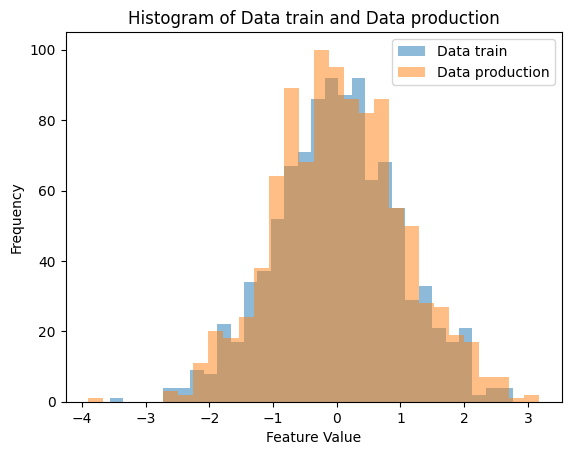

In [10]:
# Plot histograms of the two distributions
plt.hist(data_train, bins=30, alpha=0.5, label="Data train")
plt.hist(data_prod, bins=30, alpha=0.5, label="Data production")
plt.xlabel("Feature Value")
plt.ylabel("Frequency")
plt.title("Histogram of Data train and Data production")
plt.legend()
plt.show()

Then, we use the KS test to make the decision whether or not there is data drift in the continuous variable.

In [11]:
def kolmogorov_smirnov_test(data_train: np.ndarray, data_prod: np.ndarray, alpha: float = 0.05) -> float:
    """
    Perform a Kolmogorov-Smirnov test to check if there is a significant difference in the distribution of a numerical variable between two datasets.
    In other words, this test checks if there is data drift in the numerical variable distribution between the two datasets.

    Parameters:
    data_train (np.ndarray): Data for training.
    data_prod (np.ndarray): Data for production.
    alpha (float): Significance level.

    Returns:
    float: P-value of the Kolmogorov-Smirnov test.
    """
    # Perform the Kolmogorov-Smirnov test
    ks_statistic, p_value = ks_2samp(data_train, data_prod)

    alpha = 0.05

    # Print the KS test results
    print(f"KS statistic: {ks_statistic:.4f}")
    print(f"P-value: {p_value:.4f}")

    # Check if there is a significant difference
    if p_value < alpha:
        print(
            "Data drift detected: There is a significant difference in the continuos variable distribution."
        )
    else:
        print(
            "No data drift detected: There is no significant difference in the continuos variable distribution."
        )
    return p_value

In [12]:
p_value = kolmogorov_smirnov_test(data_train, data_prod)

KS statistic: 0.0360
P-value: 0.5363
No data drift detected: There is no significant difference in the continuos variable distribution.


The test **failed to reject** H0, that is, it **did not identify** data drift!

Let's test with a new dataset, with different probability distribution:

In [13]:
# Generate two example datasets
data_train = np.random.normal(loc=0, scale=1, size=1000)
data_prod = np.random.normal(loc=0.5, scale=1.2, size=1000)

p_value = kolmogorov_smirnov_test(data_train, data_prod)

KS statistic: 0.1820
P-value: 0.0000
Data drift detected: There is a significant difference in the continuos variable distribution.


The test **rejected** H0, that is, **identified** data drift!

**Tip!**

Keep in mind that monitoring model performance degradation is an ongoing process.

It is advisable to monitor metrics in real-time and to implement automated alerts to notify your team when issues arise.